# MLP
Like MLP_269 but run on every cell line individually.

In [25]:

from datetime import datetime
print(datetime.now())

2023-04-19 18:21:05.247981


In [26]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
    MODEL_DIR = '/Users/jasonmiller/WVU/Localization/Models/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [27]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.losses import Hinge

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=150 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
# MAXLEN=5000
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
# EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
REPEATS = 2
FOLDS = 5

SAVE_MODEL_FILENAME = None # 'MLP_277'

Python 3.9.16
sklearn 1.2.2


In [28]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.all_cell_lines.csv'
RCI_FILE_TEST  = None # 'test.lncRNA_RCI.all_cell_lines.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # 'test.canon_lncRNA_transcripts.csv'

In [29]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()
CELL_LINES=[4]  # just HT1080

## Data Load

In [30]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    string = fields[cell_line]
                    if string != 'nan':
                        value = float(string)
                        self.gene2rci[gene_id] = value
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        #NREPEAT = str('N'*MAXLEN)   # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # no MAXLEN for MLP
                        #if seq_len<=MAXLEN:
                        #    seq_txt = seq_txt + NREPEAT
                        #seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [31]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(128, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    drop2  = Dropout(.2)
    layer3 = Dense(64, activation='sigmoid')
    drop3  = Dropout(.2)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(drop2)
    mlp.add(layer3)
    mlp.add(drop3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [32]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-19 18:21:06.948890
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_128 (Dense)           (None, 128)               131328    
                                                                 
 dense_129 (Dense)           (None, 64)                8256      
                                                                 
 dropout_64 (Dropout)        (None, 64)                0         
                                                                 
 dense_130 (Dense)           (None, 64)                4160      
                                                                 
 dropout_65 (Dropout)        (None, 64)                0         
                                                                 
 dense_131 (Dense)           (None, 1)                 65        
                                                                 
Total params: 143,809
Trai

## Training

In [33]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = -1 # or zero
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            filepath = MODEL_DIR + filename
            self.model.save(filepath)
            print('Saved model to',filepath)
        
    def load_model(self,filename):
        filepath = MODEL_DIR + filename
        self.model = keras.models.load_model(filepath)
        print('Loaded model from',filepath)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd)  # no validation )
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)

        correct_pos = 0
        correct_neg = 0
        wrong_pos = 0
        wrong_neg = 0
        for i in range(len(y_test)):
            if yhat_pred[i]>=0.65:
                if y_test[i]==1:
                    correct_pos += 1
                else:
                    wrong_pos += 1
            elif yhat_pred[i]<=0.35:
                if y_test[i]==0:
                    correct_neg += 1
                else:
                    wrong_neg += 1
        print('Extreme scores correct, pos:neg',correct_pos,correct_neg)  
        print('Extreme scores incorrect pos:neg',wrong_pos,wrong_neg)  

        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [34]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

In [35]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)




2023-04-19 18:21:07.253706
Cell Line 4 HT1080
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 1025
Num RCI: 1025
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 1025 sequences.

Training # 1 1
2023-04-19 18:21:10.494011
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
2023-04-19 18:21:10.680371
Discriminator is GMM
Means [0.33296517993751706, -2.273509500994392]
Variances [1.32532507 2.96240249]
Priors [0.64529755 0.35470245]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 579:236 71.04%
Computed class weights: {0: 1.7266949152542372, 1: 0.7037996545768567}
Valid 1:0 145:65 69.05%
FIT
2023-04-19 18:21:13.313197


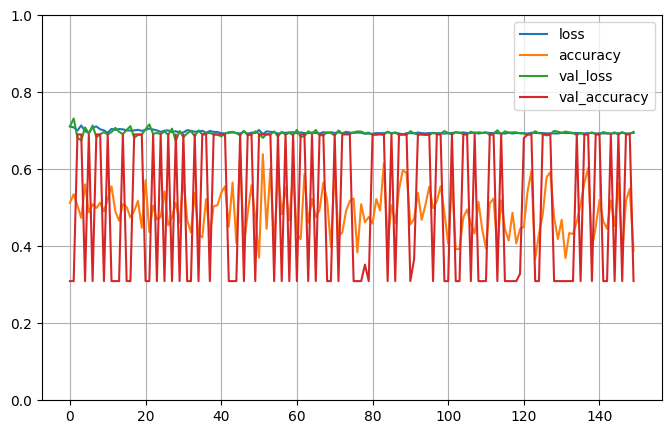


Testing # 1 1
2023-04-19 18:21:55.797709
2023-04-19 18:21:55.797766
PREDICT
2023-04-19 18:21:55.800035
Test 1:0 145:65 69.05%
Predict 1:0 0:210  0.00%
Test sizes (210, 1025) (210,)
Distrib of scores: 0.49462315 mean 0.0002719786 std
Range of scores: 0.49380788 to 0.49545705
Score threshold 0.5
Confusion matrix
 [[ 65   0]
 [145   0]]
Normalized matrix
 [[0.30952381 0.        ]
 [0.69047619 0.        ]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


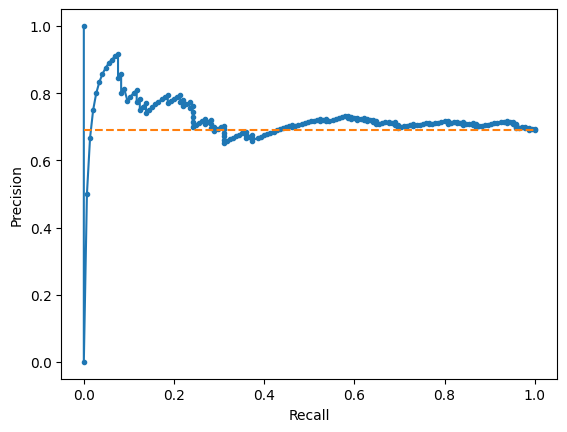

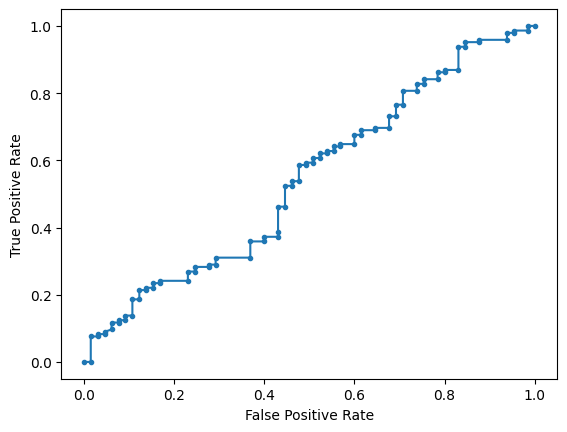

Accuracy: 30.95% Precision: 0.00% Recall: 0.00%
F1: 0.00% MCC: 0.0000
AUPRC: 72.14% AUROC: 54.44%
 accuracy [30.952380952380953]
 precision [0.0]
 recall [0.0]
 F1 [0.0]
 MCC [0.0]
 AUPRC [72.14070247385862]
 AUROC [54.435013262599476]

Training # 1 2
2023-04-19 18:21:56.449754
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
2023-04-19 18:21:56.663981
Discriminator is GMM
Means [0.39449729086390795, -2.1738351194259304]
Variances [1.32042298 2.70933315]
Priors [0.61539026 0.38460974]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 550:267 67.32%
Computed class weights: {0: 1.5299625468164795, 1: 0.7427272727272727}
Valid 1:0 141:67 67.79%
FIT
2023-04-19 18:21:57.462440


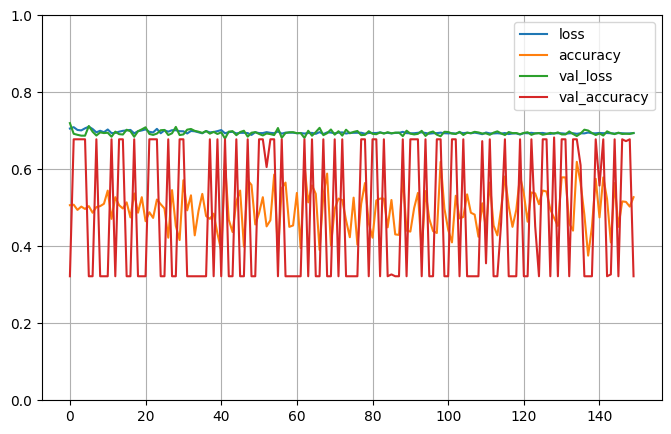


Testing # 1 2
2023-04-19 18:22:40.249294
2023-04-19 18:22:40.249345
PREDICT
2023-04-19 18:22:40.257302
Test 1:0 141:67 67.79%
Predict 1:0 0:208  0.00%
Test sizes (208, 1025) (208,)
Distrib of scores: 0.49832052 mean 0.00040490084 std
Range of scores: 0.49717137 to 0.4997078
Score threshold 0.5
Confusion matrix
 [[ 67   0]
 [141   0]]
Normalized matrix
 [[0.32211538 0.        ]
 [0.67788462 0.        ]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


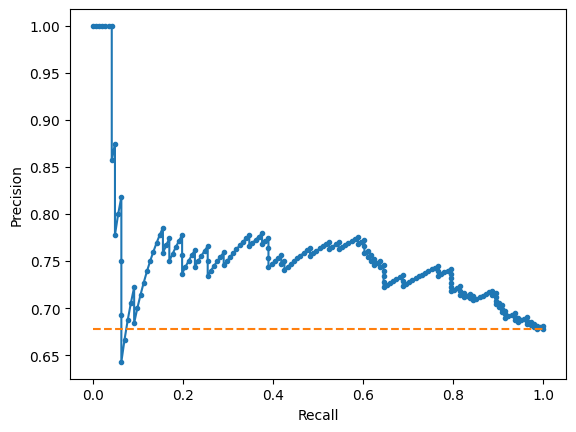

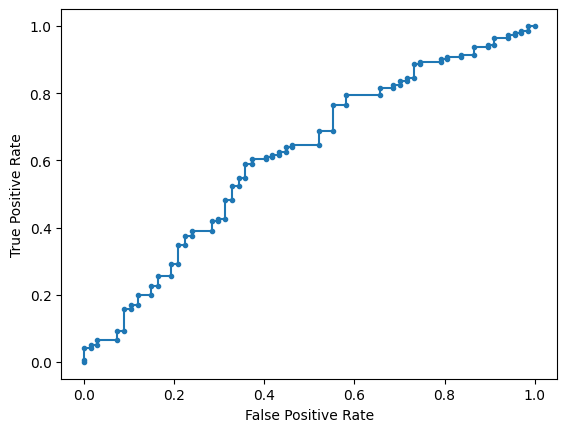

Accuracy: 32.21% Precision: 0.00% Recall: 0.00%
F1: 0.00% MCC: 0.0000
AUPRC: 75.20% AUROC: 61.33%
 accuracy [32.21153846153847]
 precision [0.0]
 recall [0.0]
 F1 [0.0]
 MCC [0.0]
 AUPRC [75.19755759597845]
 AUROC [61.33163967397057]

Training # 1 3
2023-04-19 18:22:40.887859
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
2023-04-19 18:22:41.057357
Discriminator is GMM
Means [0.47002428911164373, -2.0829525134945266]
Variances [1.27754205 2.60070329]
Priors [0.58367761 0.41632239]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 514:306 62.68%
Computed class weights: {0: 1.3398692810457515, 1: 0.7976653696498055}
Valid 1:0 140:65 68.29%
FIT
2023-04-19 18:22:41.825411


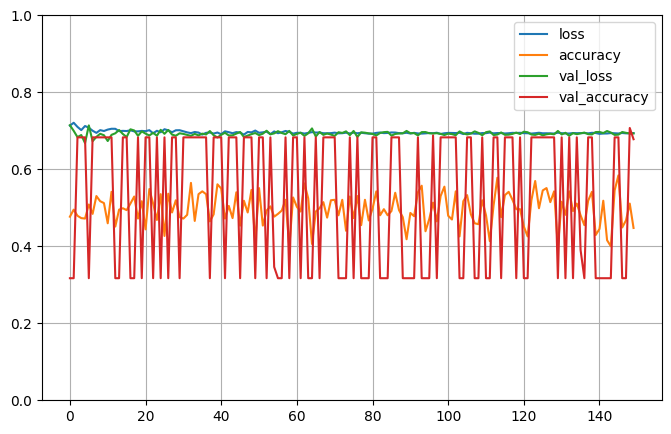


Testing # 1 3
2023-04-19 18:23:13.606845
2023-04-19 18:23:13.607229
PREDICT
2023-04-19 18:23:13.610117
Test 1:0 140:65 68.29%
Predict 1:0 136:69 66.34%
Test sizes (205, 1025) (205,)
Distrib of scores: 0.5000215 mean 6.05135e-05 std
Range of scores: 0.49990085 to 0.5002152
Score threshold 0.5
Confusion matrix
 [[ 34  31]
 [ 35 105]]
Normalized matrix
 [[0.16585366 0.15121951]
 [0.17073171 0.51219512]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


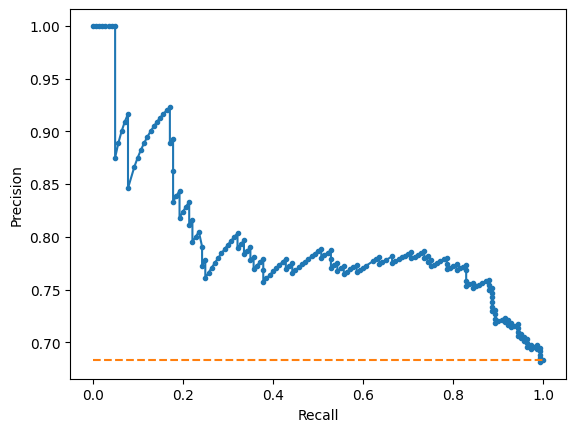

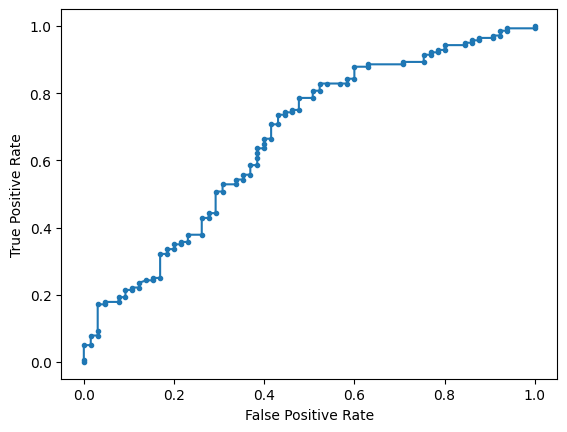

Accuracy: 67.80% Precision: 77.21% Recall: 75.00%
F1: 76.09% MCC: 0.2689
AUPRC: 79.68% AUROC: 66.54%
 accuracy [67.8048780487805]
 precision [77.20588235294117]
 recall [75.0]
 F1 [76.08695652173914]
 MCC [0.26891293784824344]
 AUPRC [79.68419095910511]
 AUROC [66.54395604395604]

Training # 1 4
2023-04-19 18:23:14.487626
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
2023-04-19 18:23:14.671318
Discriminator is GMM
Means [0.49767973268216015, -2.0669906939797786]
Variances [1.34218325 2.78678539]
Priors [0.61194447 0.38805553]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 549:276 66.55%
Computed class weights: {0: 1.4945652173913044, 1: 0.7513661202185792}
Valid 1:0 119:81 59.50%
FIT
2023-04-19 18:23:16.892140


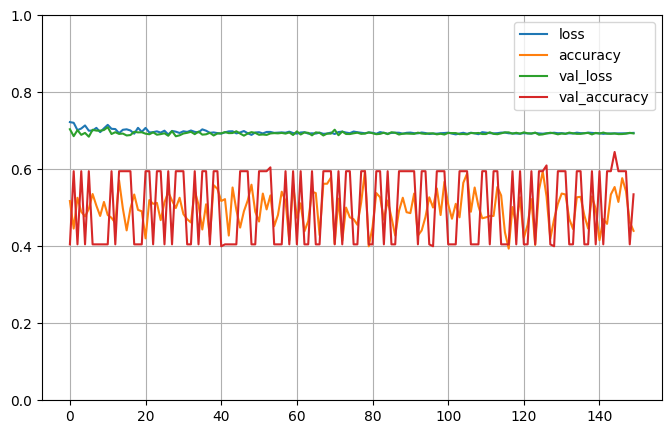


Testing # 1 4
2023-04-19 18:23:47.571051
2023-04-19 18:23:47.571101
PREDICT
2023-04-19 18:23:47.573554
Test 1:0 119:81 59.50%
Predict 1:0 66:134 33.00%
Test sizes (200, 1025) (200,)
Distrib of scores: 0.49995318 mean 0.0002575554 std
Range of scores: 0.4994246 to 0.5009315
Score threshold 0.5
Confusion matrix
 [[61 20]
 [73 46]]
Normalized matrix
 [[0.305 0.1  ]
 [0.365 0.23 ]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


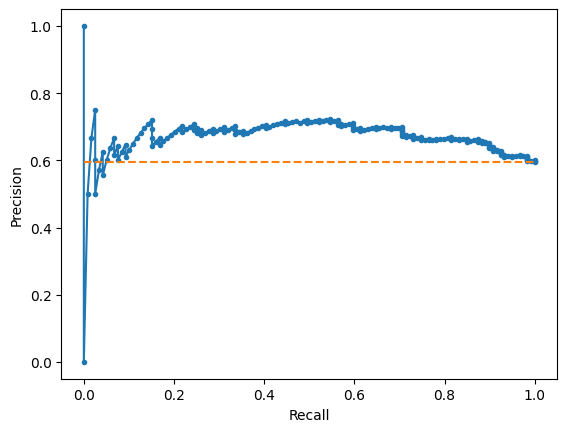

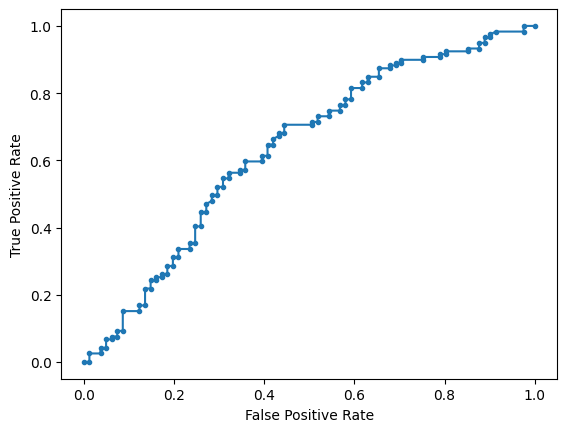

Accuracy: 53.50% Precision: 69.70% Recall: 38.66%
F1: 49.73% MCC: 0.1458
AUPRC: 66.96% AUROC: 63.66%
 accuracy [53.5]
 precision [69.6969696969697]
 recall [38.655462184873954]
 F1 [49.72972972972973]
 MCC [0.1457822681142118]
 AUPRC [66.96404016784767]
 AUROC [63.66324307500778]

Training # 1 5
2023-04-19 18:23:48.209746
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
2023-04-19 18:23:48.417484
Discriminator is GMM
Means [0.4154628668808877, -2.1625082510580476]
Variances [1.29329676 2.96157665]
Priors [0.60885246 0.39114754]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 547:276 66.46%
Computed class weights: {0: 1.4909420289855073, 1: 0.7522851919561243}
Valid 1:0 137:65 67.82%
FIT
2023-04-19 18:23:49.192692


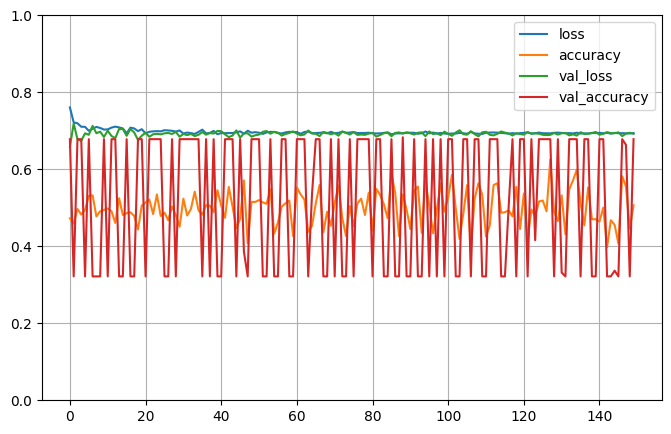


Testing # 1 5
2023-04-19 18:24:31.637021
2023-04-19 18:24:31.637069
PREDICT
2023-04-19 18:24:31.644921
Test 1:0 137:65 67.82%
Predict 1:0 202:0 100.00%
Test sizes (202, 1025) (202,)
Distrib of scores: 0.5012166 mean 0.0003338422 std
Range of scores: 0.500346 to 0.50227684
Score threshold 0.5
Confusion matrix
 [[  0  65]
 [  0 137]]
Normalized matrix
 [[0.         0.32178218]
 [0.         0.67821782]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


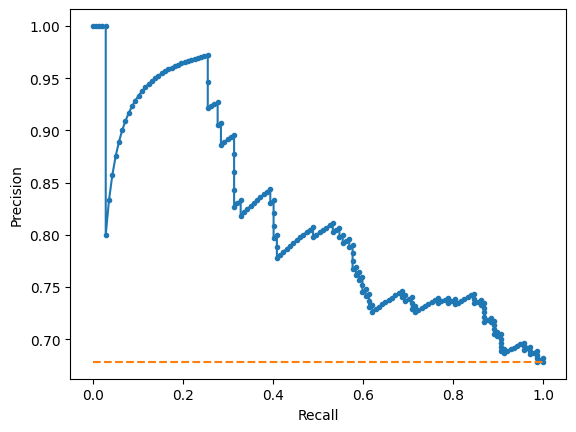

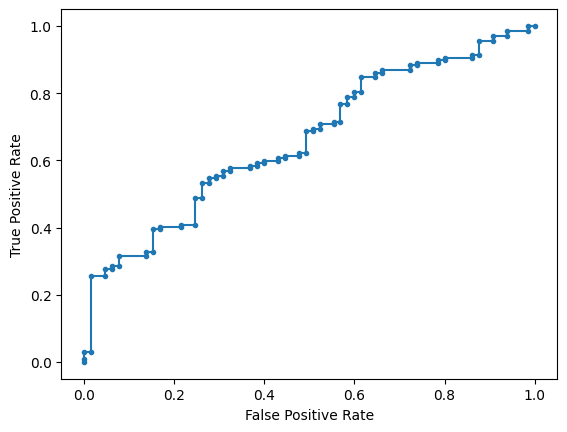

Accuracy: 67.82% Precision: 67.82% Recall: 100.00%
F1: 80.83% MCC: 0.0000
AUPRC: 81.34% AUROC: 66.22%
 accuracy [67.82178217821783]
 precision [67.82178217821783]
 recall [100.0]
 F1 [80.8259587020649]
 MCC [0.0]
 AUPRC [81.33948952368256]
 AUROC [66.221224031443]

Training # 2 1
2023-04-19 18:24:32.244585
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
2023-04-19 18:24:32.426110
Discriminator is GMM
Means [0.495179773718353, -2.026524136545443]
Variances [1.27756552 2.59424979]
Priors [0.60228457 0.39771543]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 547:299 64.66%
Computed class weights: {0: 1.414715719063545, 1: 0.773308957952468}
Valid 1:0 109:70 60.89%
FIT
2023-04-19 18:24:33.179146


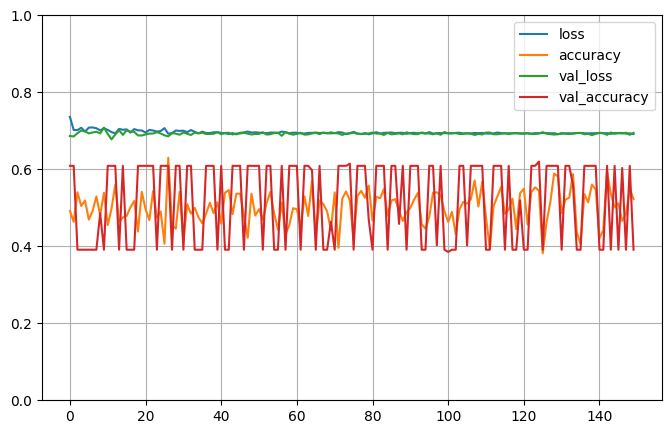


Testing # 2 1
2023-04-19 18:25:15.567335
2023-04-19 18:25:15.567417
PREDICT
2023-04-19 18:25:15.570927
Test 1:0 109:70 60.89%
Predict 1:0 0:179  0.00%
Test sizes (179, 1025) (179,)
Distrib of scores: 0.496577 mean 0.0004667547 std
Range of scores: 0.49559072 to 0.4982491
Score threshold 0.5
Confusion matrix
 [[ 70   0]
 [109   0]]
Normalized matrix
 [[0.39106145 0.        ]
 [0.60893855 0.        ]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


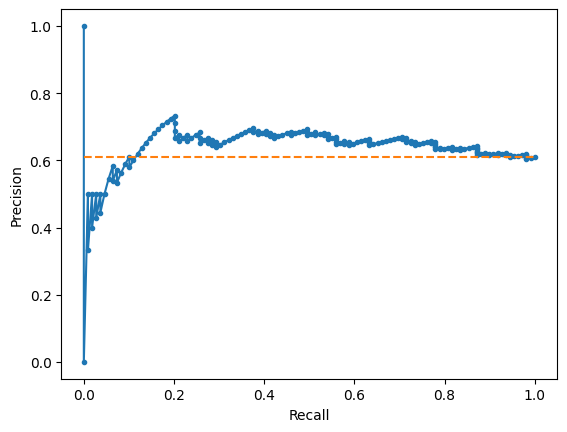

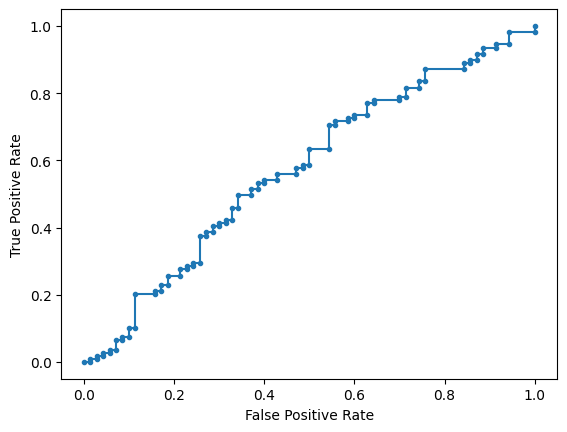

Accuracy: 39.11% Precision: 0.00% Recall: 0.00%
F1: 0.00% MCC: 0.0000
AUPRC: 63.94% AUROC: 57.38%
 accuracy [39.10614525139665]
 precision [0.0]
 recall [0.0]
 F1 [0.0]
 MCC [0.0]
 AUPRC [63.94200662319663]
 AUROC [57.37876802096986]

Training # 2 2
2023-04-19 18:25:16.289163
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
2023-04-19 18:25:16.450385
Discriminator is GMM
Means [-2.1937179315514674, 0.4022507795776563]
Variances [2.80484761 1.27204342]
Priors [0.39826769 0.60173231]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 537:282 65.57%
Computed class weights: {0: 1.452127659574468, 1: 0.7625698324022346}
Valid 1:0 145:61 70.39%
FIT
2023-04-19 18:25:17.224451


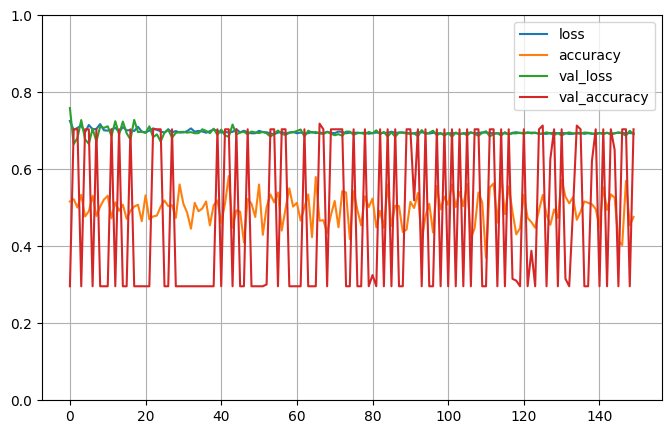


Testing # 2 2
2023-04-19 18:26:00.559854
2023-04-19 18:26:00.563232
PREDICT
2023-04-19 18:26:00.566123
Test 1:0 145:61 70.39%
Predict 1:0 206:0 100.00%
Test sizes (206, 1025) (206,)
Distrib of scores: 0.50273883 mean 0.00016595189 std
Range of scores: 0.5023165 to 0.5032272
Score threshold 0.5
Confusion matrix
 [[  0  61]
 [  0 145]]
Normalized matrix
 [[0.        0.2961165]
 [0.        0.7038835]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


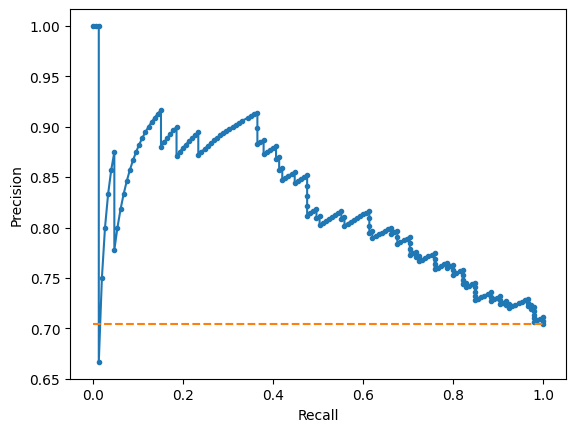

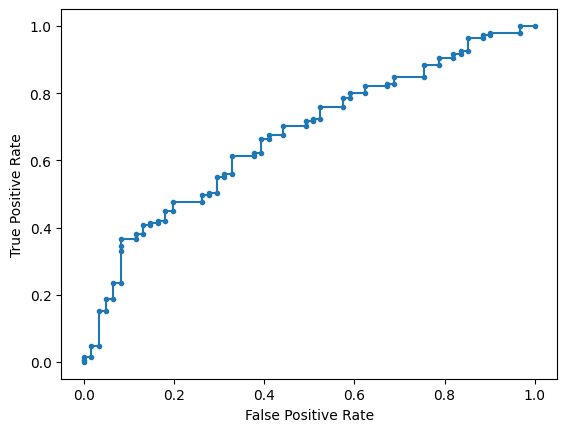

Accuracy: 70.39% Precision: 70.39% Recall: 100.00%
F1: 82.62% MCC: 0.0000
AUPRC: 82.03% AUROC: 67.30%
 accuracy [70.3883495145631]
 precision [70.3883495145631]
 recall [100.0]
 F1 [82.62108262108264]
 MCC [0.0]
 AUPRC [82.02562866558293]
 AUROC [67.30356133408705]

Training # 2 3
2023-04-19 18:26:01.552434
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
2023-04-19 18:26:01.756379
Discriminator is GMM
Means [0.43335132167967844, -2.083160148512902]
Variances [1.34789546 2.83393966]
Priors [0.59761651 0.40238349]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 541:291 65.02%
Computed class weights: {0: 1.429553264604811, 1: 0.7689463955637708}
Valid 1:0 132:61 68.39%
FIT
2023-04-19 18:26:03.625558


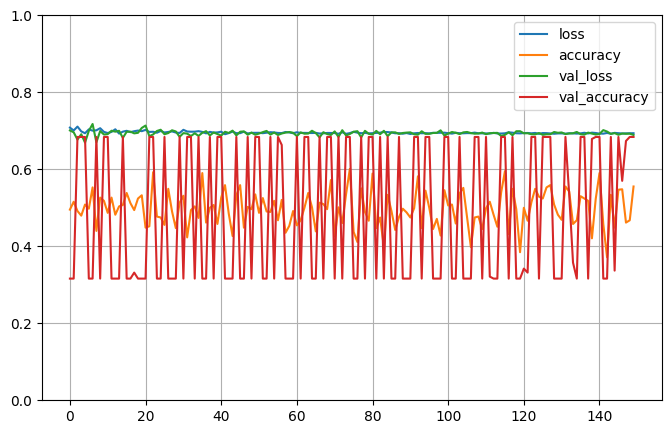


Testing # 2 3
2023-04-19 18:26:34.325062
2023-04-19 18:26:34.325110
PREDICT
2023-04-19 18:26:34.327013
Test 1:0 132:61 68.39%
Predict 1:0 193:0 100.00%
Test sizes (193, 1025) (193,)
Distrib of scores: 0.50533783 mean 0.00059010973 std
Range of scores: 0.50421506 to 0.50751096
Score threshold 0.5
Confusion matrix
 [[  0  61]
 [  0 132]]
Normalized matrix
 [[0.         0.31606218]
 [0.         0.68393782]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


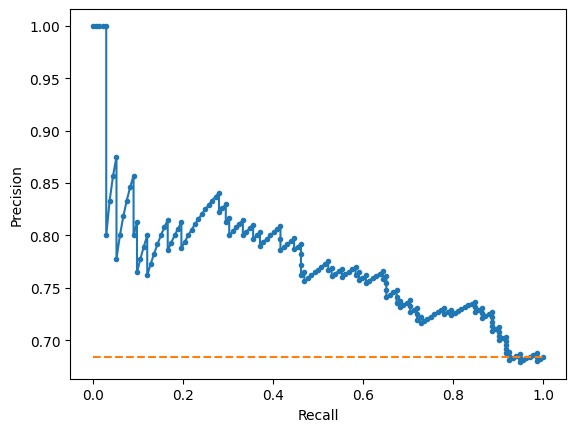

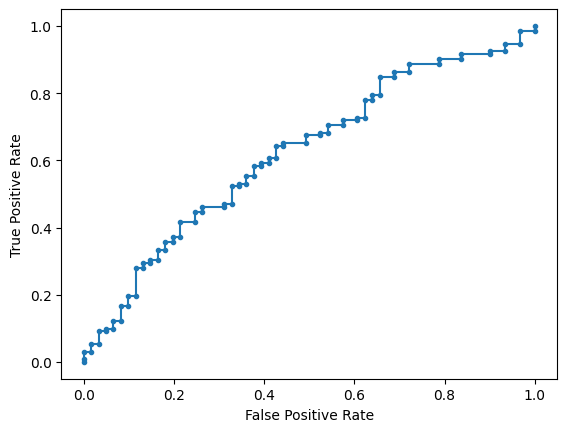

Accuracy: 68.39% Precision: 68.39% Recall: 100.00%
F1: 81.23% MCC: 0.0000
AUPRC: 77.31% AUROC: 62.38%
 accuracy [68.39378238341969]
 precision [68.39378238341969]
 recall [100.0]
 F1 [81.23076923076923]
 MCC [0.0]
 AUPRC [77.30539732280866]
 AUROC [62.38201689021362]

Training # 2 4
2023-04-19 18:26:34.987549
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
2023-04-19 18:26:35.194353
Discriminator is GMM
Means [-2.1381057628824265, 0.46083751158935343]
Variances [2.96413242 1.26802713]
Priors [0.38717452 0.61282548]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 529:262 66.88%
Computed class weights: {0: 1.5095419847328244, 1: 0.7476370510396976}
Valid 1:0 148:86 63.25%
FIT
2023-04-19 18:26:37.004388


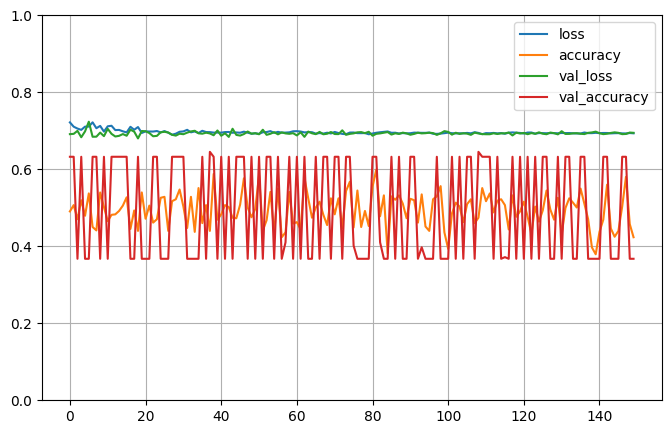


Testing # 2 4
2023-04-19 18:27:07.994560
2023-04-19 18:27:07.995035
PREDICT
2023-04-19 18:27:07.998319
Test 1:0 148:86 63.25%
Predict 1:0 0:234  0.00%
Test sizes (234, 1025) (234,)
Distrib of scores: 0.49703854 mean 0.00015585132 std
Range of scores: 0.49671945 to 0.49757335
Score threshold 0.5
Confusion matrix
 [[ 86   0]
 [148   0]]
Normalized matrix
 [[0.36752137 0.        ]
 [0.63247863 0.        ]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


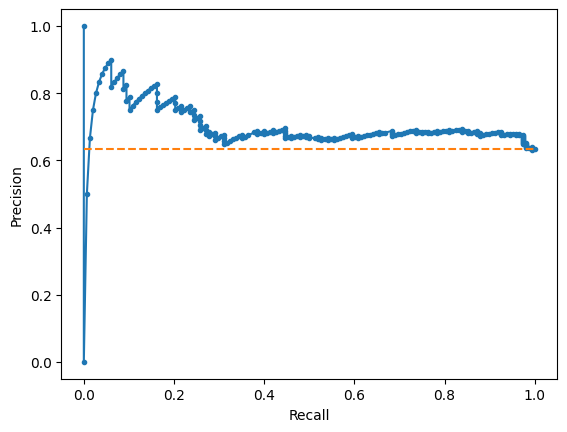

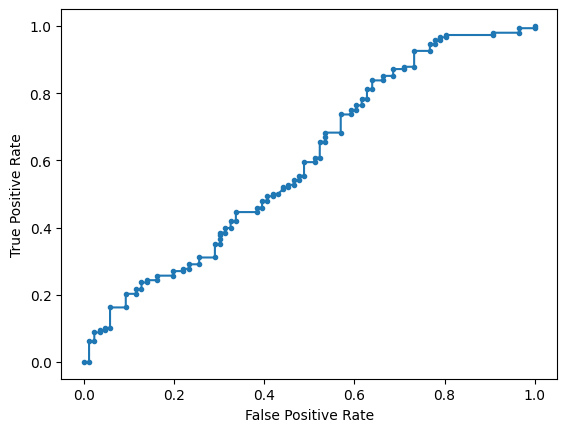

Accuracy: 36.75% Precision: 0.00% Recall: 0.00%
F1: 0.00% MCC: 0.0000
AUPRC: 70.06% AUROC: 59.81%
 accuracy [36.75213675213676]
 precision [0.0]
 recall [0.0]
 F1 [0.0]
 MCC [0.0]
 AUPRC [70.06322791712158]
 AUROC [59.81301068510372]

Training # 2 5
2023-04-19 18:27:08.633009
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
2023-04-19 18:27:08.824274
Discriminator is GMM
Means [0.3170483815562847, -2.3226078365630305]
Variances [1.39545727 2.79823823]
Priors [0.65071891 0.34928109]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 580:232 71.43%
Computed class weights: {0: 1.75, 1: 0.7}
Valid 1:0 156:57 73.24%
FIT
2023-04-19 18:27:11.435187


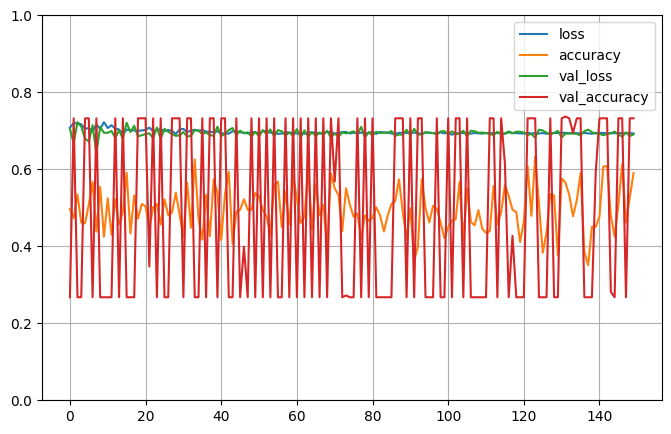


Testing # 2 5
2023-04-19 18:27:42.534088
2023-04-19 18:27:42.534479
PREDICT
2023-04-19 18:27:42.538059
Test 1:0 156:57 73.24%
Predict 1:0 213:0 100.00%
Test sizes (213, 1025) (213,)
Distrib of scores: 0.5024749 mean 0.0002459606 std
Range of scores: 0.5017042 to 0.5033766
Score threshold 0.5
Confusion matrix
 [[  0  57]
 [  0 156]]
Normalized matrix
 [[0.         0.26760563]
 [0.         0.73239437]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


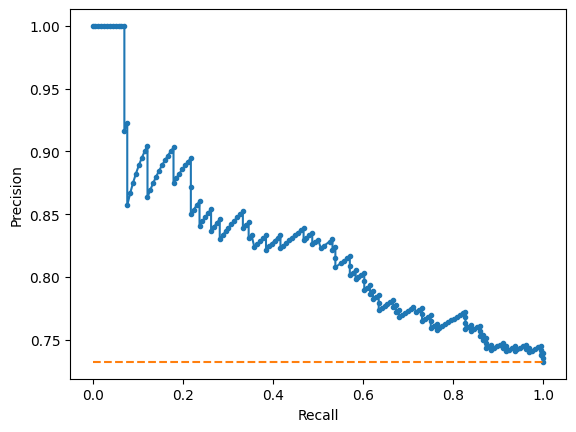

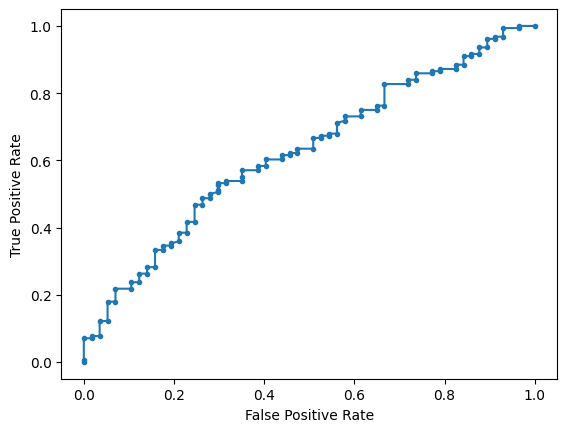

Accuracy: 73.24% Precision: 73.24% Recall: 100.00%
F1: 84.55% MCC: 0.0000
AUPRC: 82.33% AUROC: 62.59%
 accuracy [73.23943661971832]
 precision [73.23943661971832]
 recall [100.0]
 F1 [84.5528455284553]
 MCC [0.0]
 AUPRC [82.33474616382817]
 AUROC [62.589968511021134]
 accuracy mean 54.02% std 17.49
 precision mean 42.67% std 36.82
 recall mean 51.37% std 48.00
 F1 mean 45.50% std 40.36
 MCC mean 0.0415 std 0.0921
 AUPRC mean 75.10% std 6.58
 AUROC mean 62.17% std 4.13
 accuracy [[30.952380952380953], [32.21153846153847], [67.8048780487805], [53.5], [67.82178217821783], [39.10614525139665], [70.3883495145631], [68.39378238341969], [36.75213675213676], [73.23943661971832]]
 precision [[0.0], [0.0], [77.20588235294117], [69.6969696969697], [67.82178217821783], [0.0], [70.3883495145631], [68.39378238341969], [0.0], [73.23943661971832]]
 recall [[0.0], [0.0], [75.0], [38.655462184873954], [100.0], [0.0], [100.0], [100.0], [0.0], [100.0]]
 F1 [[0.0], [0.0], [76.08695652173914], [49.729729729

In [36]:
for cell_line in CELL_LINES:
    print()
    print(datetime.now())
    print('Cell Line',cell_line,all_cell_lines[cell_line])

    accuracy=[]
    precision=[]
    recall=[]
    f1=[]
    mcc=[]
    auprc=[]
    auroc=[]

    loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TRAIN
    print("Load RCI from",filepath)
    gene_to_rci = loader.load_gene_rci_values(filepath,cell_line)
    print('Num RCI:', len(gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TRAIN
    print('Load sequence from',filepath)
    allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
    print('Loaded',len(allseq),'sequences.')
    test_gene_to_rci = None
    test_allids = None
    test_allseq = None
    if SEQ_FILE_TEST is not None:
        # Train on the entire train set (no cross-validation).
        # Evaluate with the test files.
        test_loader = DataLoader()
        filepath = DATA_DIR+RCI_FILE_TEST
        print("Load RCI from",filepath)
        test_gene_to_rci = test_loader.load_gene_rci_values(filepath,cell_line)
        print('Num RCI:', len(test_gene_to_rci.keys()))
        filepath = DATA_DIR+SEQ_FILE_TEST
        print('Load sequence from',filepath)
        test_allids,test_allseq = test_loader.load_spectra(filepath)
        print('Loaded',len(test_allseq),'sequences.')

    for repeat in range(REPEATS):
        for fold in range(FOLDS):
            show_r = repeat+1  # display one-based counting
            show_f = fold+1    # display one-based counting

            print()
            print("Training #",show_r,show_f)
            print(datetime.now())
            cvdo = CrossValidator(EPOCHS)
            cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
            if SEQ_FILE_TEST is None:
                # Train on 80% and evaluate on 20%.
                separator = Separator()
                separator.load(DATA_DIR,show_r,show_f)
                separator.process(allids,allseq,gene_to_rci)
                train_allids,test_allids = separator.get_ids()
                train_allseq,test_allseq = separator.get_seq()
                train_gene_to_rci,test_gene_to_rci = separator.get_rci()
                cvdo.train_new_model(
                    train_allids,train_allseq,train_gene_to_rci,
                    test_allids,test_allseq,test_gene_to_rci)
                if SAVE_MODEL_FILENAME is not None:
                    filename = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                    cvdo.save_model(filename)
            else:
                # Train on the entire train set (no cross-validation).
                # Evaluate with the test files.
                train_allids = allids
                train_allseq = allseq
                train_gene_to_rci = gene_to_rci
                BREAK = True
                cvdo.train_new_model(
                    train_allids,train_allseq,train_gene_to_rci,
                    None,None,None)

            print()
            print("Testing #",show_r,show_f)
            print(datetime.now())
            cvdo.reset_statistics()
            cvdo.test_without_training(
                test_allids,test_allseq,test_gene_to_rci)
            cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
                cvdo.get_statistics()

            print(" accuracy" ,  cv_accuracy)
            print(" precision" , cv_precision)
            print(" recall" ,    cv_recall)
            print(" F1" ,        cv_f1)
            print(" MCC" ,       cv_mcc)
            print(" AUPRC" ,     cv_auprc)
            print(" AUROC" ,     cv_auroc)

            accuracy.append(cv_accuracy)
            precision.append(cv_precision)
            recall.append(cv_recall)
            f1.append(cv_f1)
            mcc.append(cv_mcc)
            auprc.append(cv_auprc)
            auroc.append(cv_auroc)
            if BREAK: break
        if BREAK: break

    print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
    print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
    print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
    print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
    print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
    print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
    print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

    print(" accuracy"  , accuracy)
    print(" precision" , precision)
    print(" recall"    , recall)
    print(" F1"        , f1)
    print(" MCC"       , mcc)
    print(" AUPRC"     , auprc)
    print(" AUROC"     , auroc)
print(datetime.now())